In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report
import matplotlib.pyplot as plt
from lib.transformers_explainability import *

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_UNCLEANED = DatasetEnum.GoEmotions
SEED_VAL = 777
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'Roberta'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
FROZEN_LAYERS = 9
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# Cross Validation

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [16, 32],
    'epochs': [EPOCHS],
    'frozen_layers': [FROZEN_LAYERS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

0it [00:00, ?it/s]

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['frozen_layers'] = int(BEST_PARAMS['frozen_layers'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])
print(BEST_PARAMS)

BEST MODEL INFO
{'batch_size': 32.0, 'epochs': 6.0, 'frozen_layers': 9.0, 'learning_rate': 5e-05, 'n_classes': 28.0, 'regularization': 1e-05, 'train_accuracy': 0.5037318590186592, 'train_jaccard_macro': 0.4131293189336031, 'train_f1_macro': 0.5690887372934065, 'train_jaccard_samples': 0.6069016355678416, 'train_f1_micro': 0.6509211883037295, 'train_membership': 0.6852338170928357, 'val_accuracy': 0.4776999631404349, 'val_jaccard_macro': 0.373276503777086, 'val_f1_macro': 0.5254690426346077, 'val_jaccard_samples': 0.5719744440348937, 'val_f1_micro': 0.6097826086956522, 'val_membership': 0.6411721341688168}
RESULTS
   batch_size  epochs  frozen_layers  learning_rate  n_classes  \
0          16       6              9        0.00005         28   
1          32       6              9        0.00005         28   
2          16       6              9        0.00005         28   
3          32       6              9        0.00005         28   
4          16       6              9        0.000

In [5]:
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


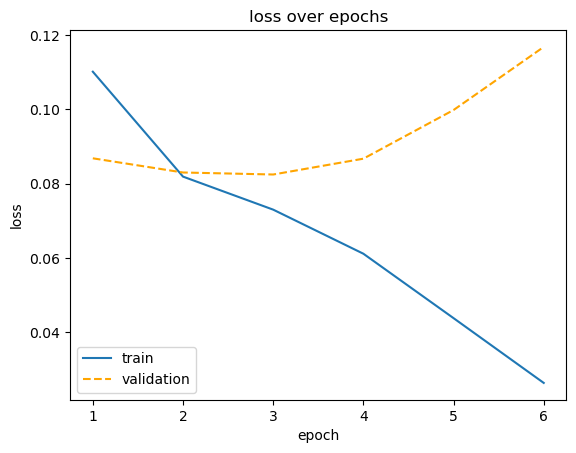

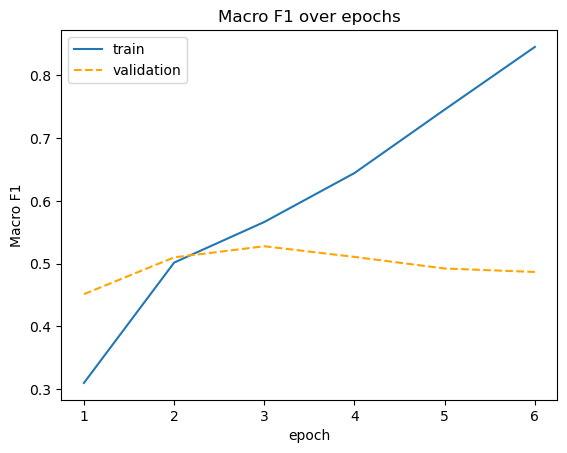

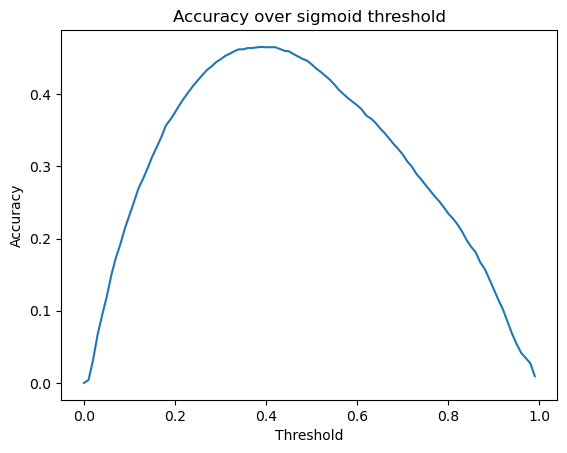

Best threshold: 0.39
Best Accuracy: 0.4655363066715813


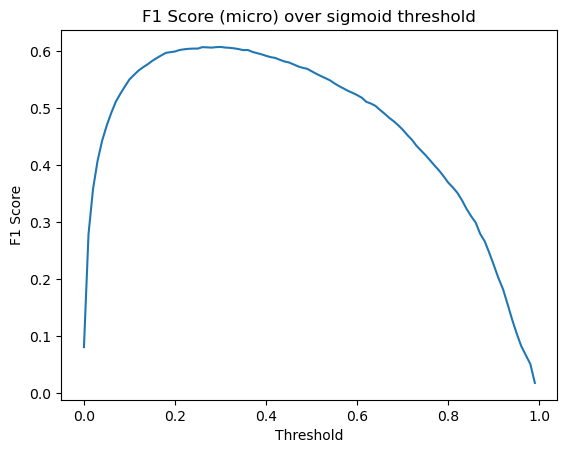

Best threshold: 0.3
Best F1 Score (micro): 0.6078416209109891


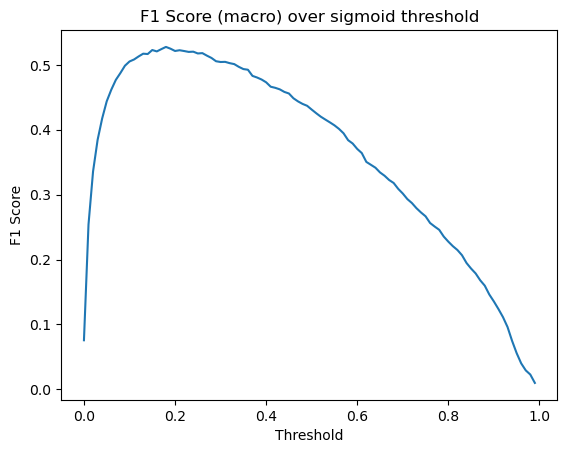

Best threshold: 0.18
Best F1 Score (macro): 0.5275957787305248


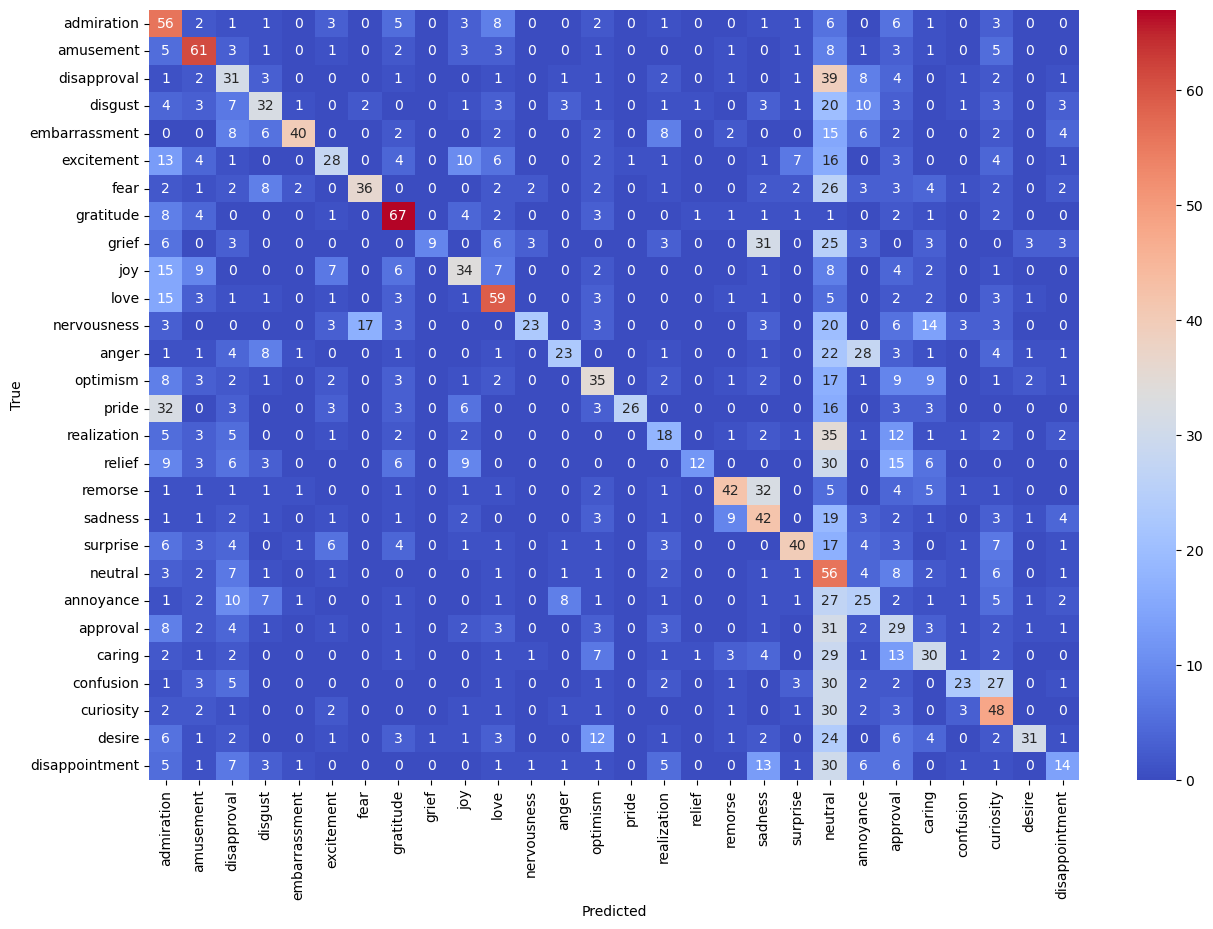

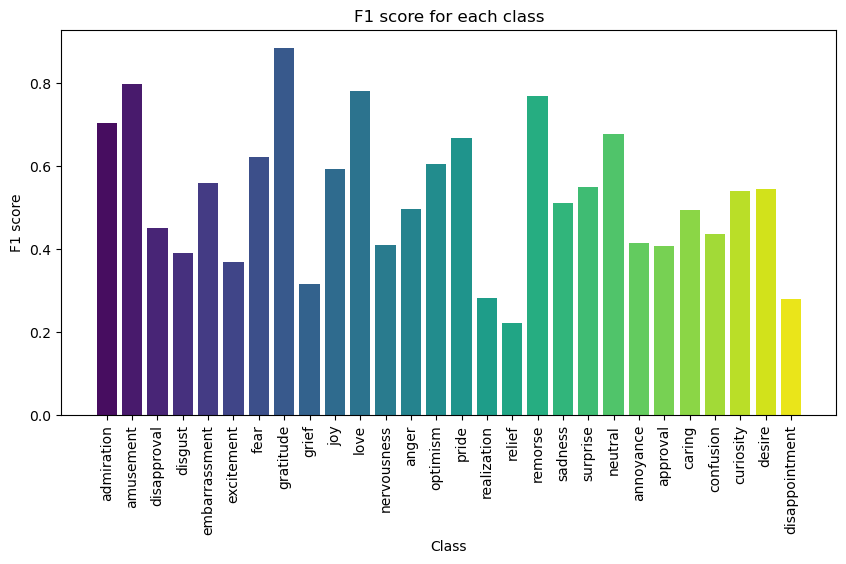

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.60                0.85                0.70                0.54                 488
amusement                           0.72                0.90                0.80                0.66                 303
disapproval                         0.35                0.62                0.45                0.29                 292
disgust                             0.31                0.52                0.39                0.24                  97
embarrassment                       0.58                0.54                0.56                0.39                  35
excitement                          0.30                0.48                0.37                0.23                  96
fear                                0.77                0.52                0.62                0.45                  90
gratitude

In [24]:
model_analysis(model, val_df, LABEL_COLS)#TODO refit for internal scores in plot

## Cleaning Validation

Attempt with no cleaning

In [5]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_uncleaned.pth'
train_df, val_df, test_df = load_dataset(DATASET_UNCLEANED, k_hot_encode=True)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
BEST_PARAMS_UNCLEANED = BEST_PARAMS.copy()
BEST_PARAMS_UNCLEANED['tokenizer_max_len'] = 48# for memory reasons (only few records affected and truncated)#TODO check amounts

In [6]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS_UNCLEANED, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


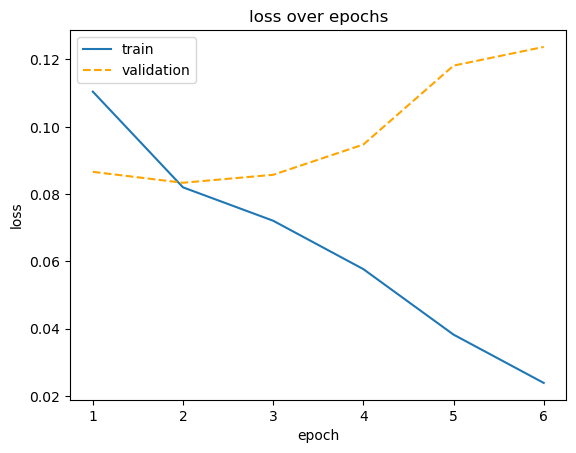

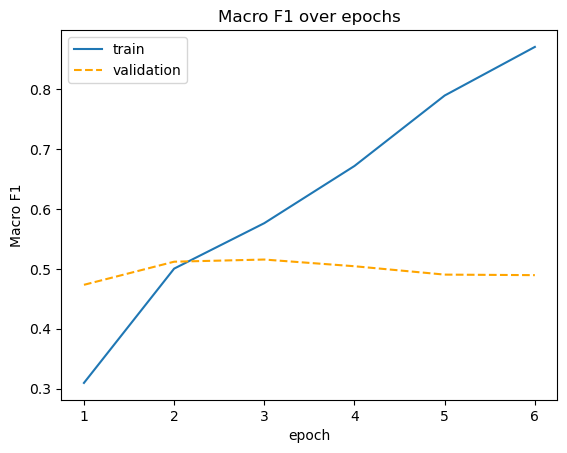

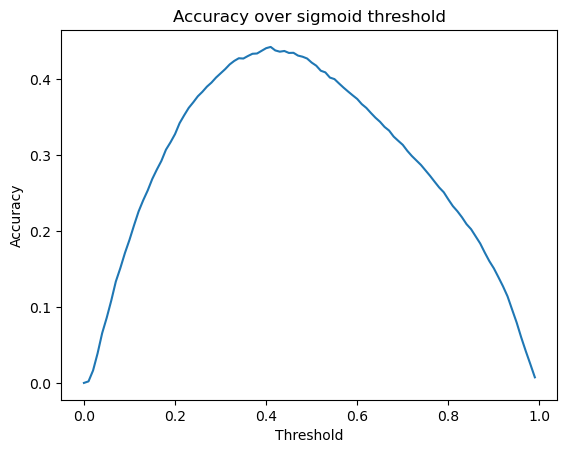

Best threshold: 0.41000000000000003
Best Accuracy: 0.44268337633615923


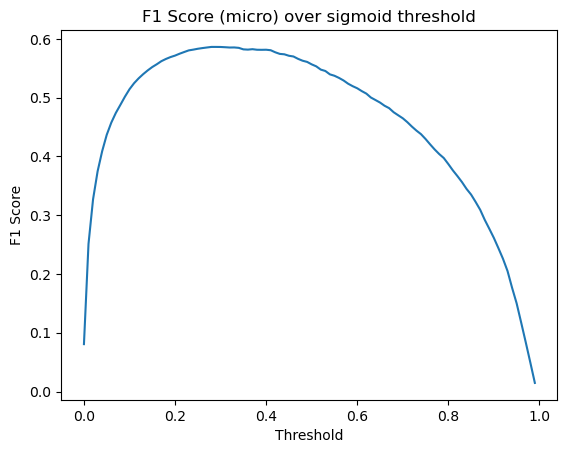

Best threshold: 0.28
Best F1 Score (micro): 0.5862417075281223


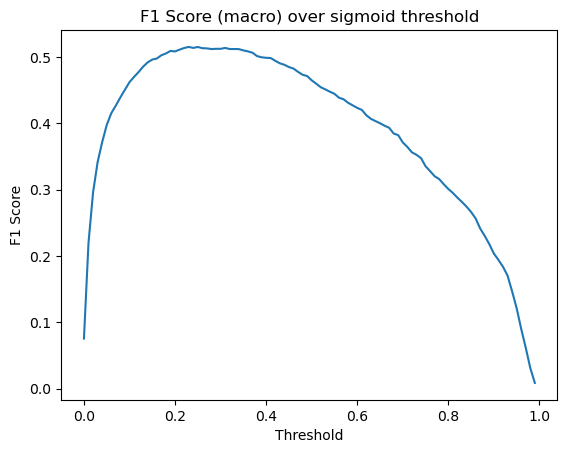

Best threshold: 0.23
Best F1 Score (macro): 0.515492887793536


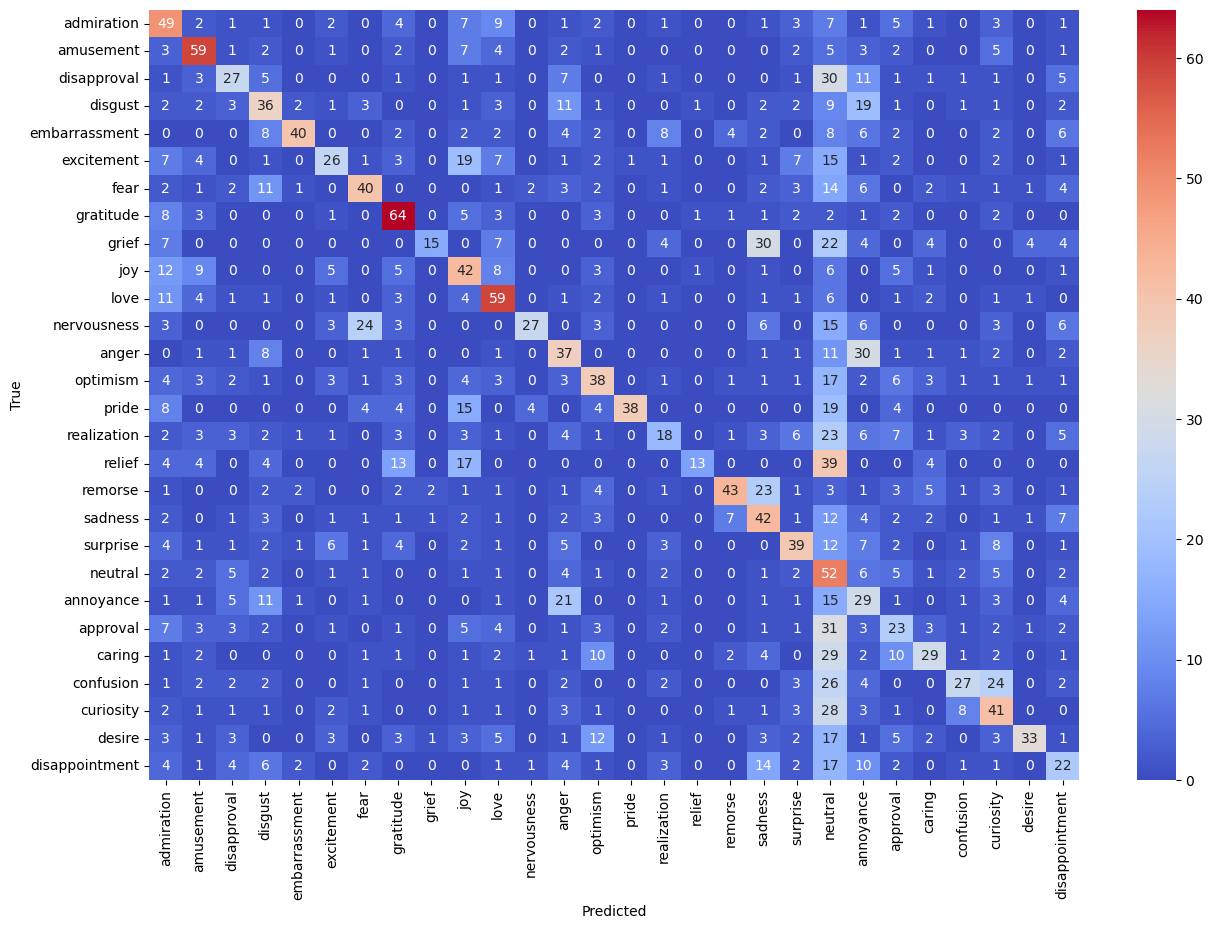

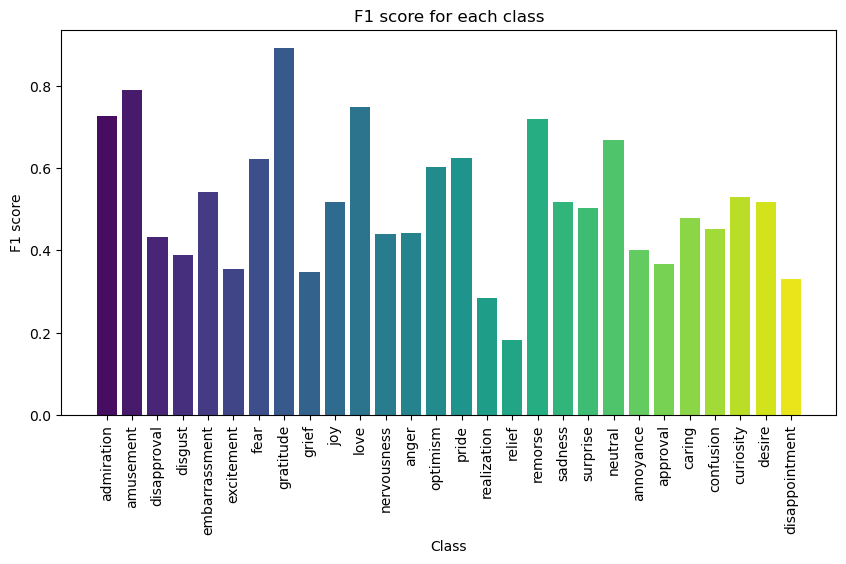

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.69                0.77                0.73                0.57                 488
amusement                           0.72                0.88                0.79                0.66                 303
disapproval                         0.40                0.47                0.43                0.28                 292
disgust                             0.27                0.69                0.39                0.24                  97
embarrassment                       0.54                0.54                0.54                0.37                  35
excitement                          0.30                0.44                0.36                0.22                  96
fear                                0.58                0.68                0.62                0.45                  90
gratitude

In [7]:
model_analysis(model, val_df, LABEL_COLS)

In [7]:
out_uncleaned = model.predict(val_df)
target = val_df[LABEL_COLS].values
best_thresh, _ = tune_sigmoid_threshold(target, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
out_uncleaned = (out_uncleaned > best_thresh).astype(int)

With cleaning

In [8]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_cleaned_seq.pth'
train_df, val_df, test_df = load_dataset(DATASET)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

In [9]:
model = Roberta({'f1_macro':f1}, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True, shuffle_training=False)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
out_cleaned = model.predict(val_df)
best_thresh, _ = tune_sigmoid_threshold(target, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
out_cleaned = (out_cleaned > best_thresh).astype(int)

Comparison

C:\Users\andre\AppData\Local\Temp\ipykernel_340\3911376436.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


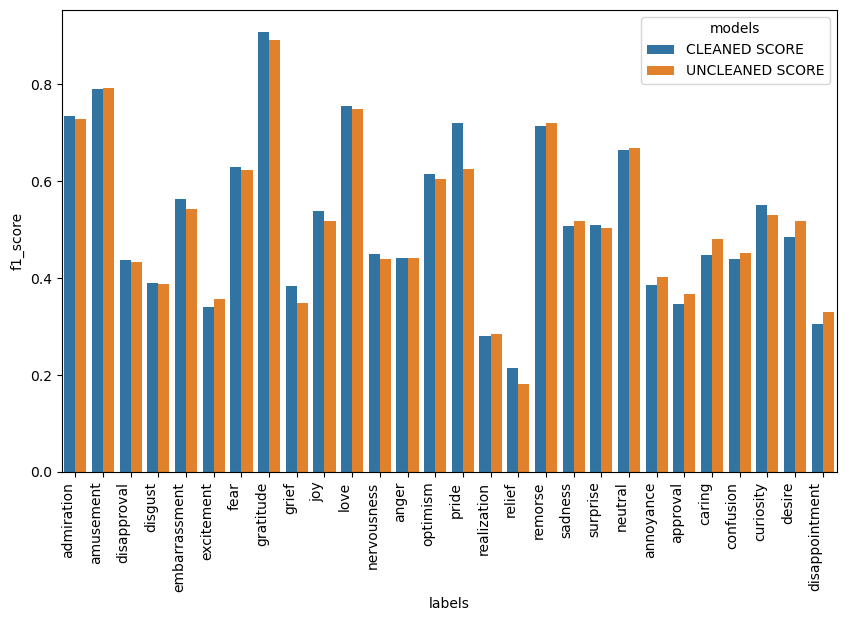

cleaned mean = 0.5196747999692459
uncleaned mean = 0.515492887793536


In [11]:

cleaned_score = f1_score(target, out_cleaned,average=None)
uncleaned_score = f1_score(target, out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned macro avg = {np.mean(cleaned_score)}\nuncleaned macro avg = {np.mean(uncleaned_score)}")

## Attempt on grouped emotions

### Mapping predictions to Ekman

In [19]:
train_df, val_df, test_df = load_dataset(DATASET)

In [20]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME  + '_' + MODEL_NAME + '.pth'
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# get model predictions on validation set
out = model.predict(val_df)
# get best threshold
thresh, _ = tune_sigmoid_threshold(val_df[LABEL_COLS].values, out, f1_score, metric_params={'average':'macro', 'zero_division':0})

In [22]:
# map dataset emotions to Ekman taxonomy
train_df = goemotions_apply_emotion_mapping(train_df)
val_df = goemotions_apply_emotion_mapping(val_df)
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
# keep only grouped records
test_df = test_df.loc[grouped_test_df.index]
# names starting with 'ekman_' are the mapped emotions
EKMAN_LABELS = grouped_test_df.columns[grouped_test_df.columns.str.startswith('ekman_')].tolist()

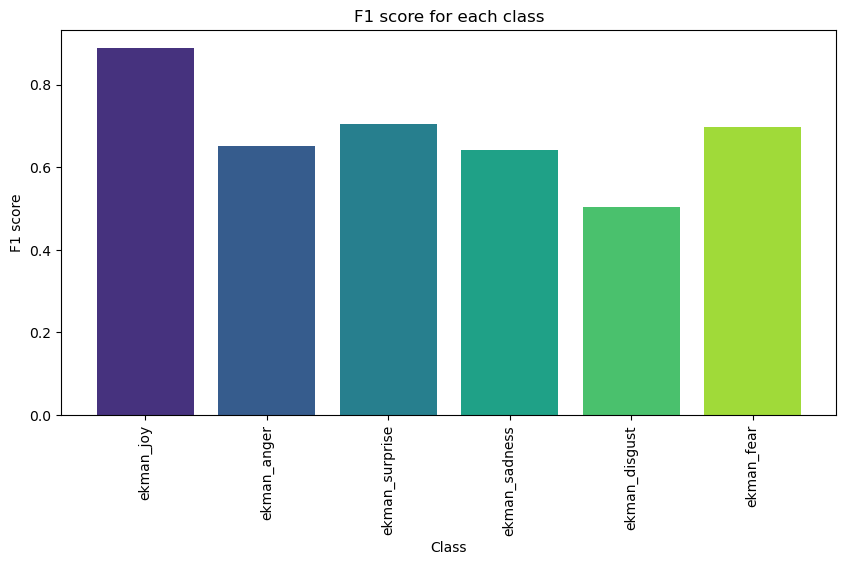

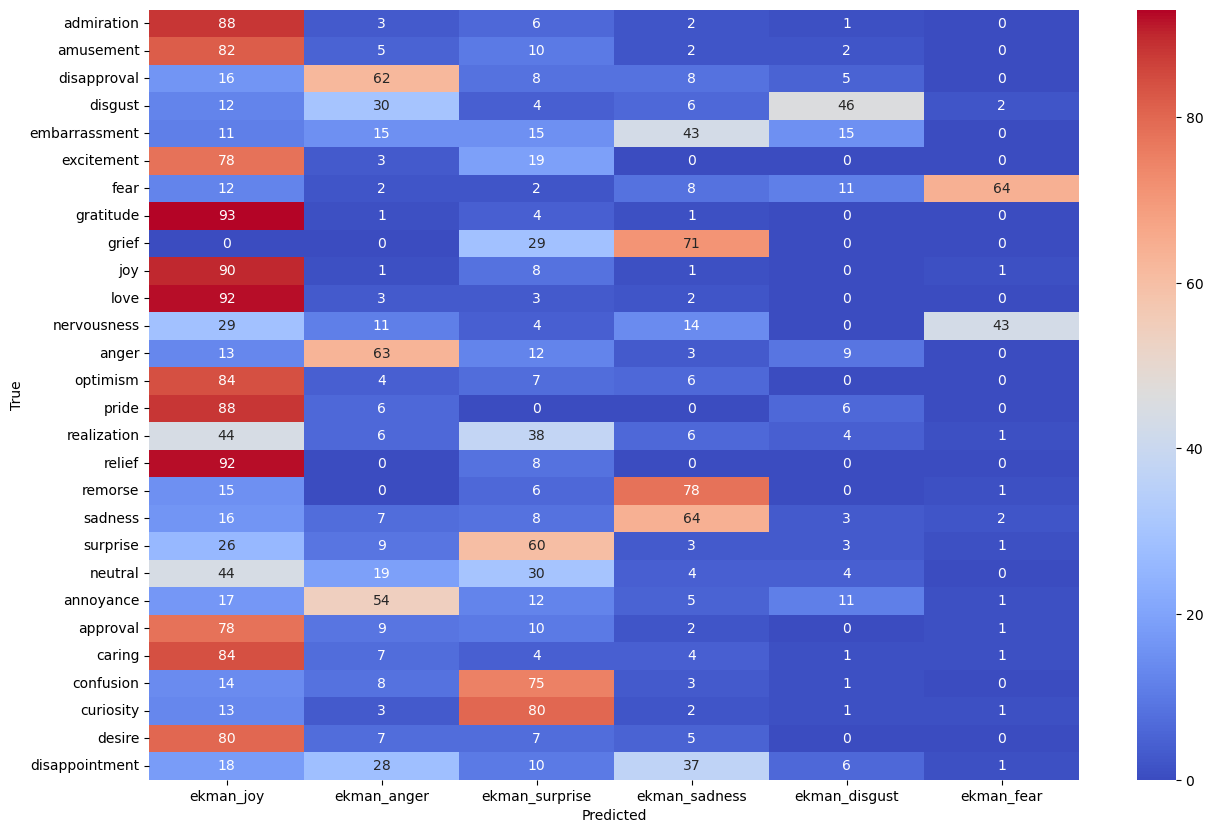

In [23]:
best_out = (model.predict(grouped_test_df) > thresh).astype(int)
best_out = goemotions_apply_emotion_mapping(best_out, isDataframe=False)
# plot bar plot
plot_score_barplot(grouped_test_df[EKMAN_LABELS].values, best_out, EKMAN_LABELS)
# visualize confusion matrix to understand induced mapping
plot_multilabel_confusion_heatmap(test_df[LABEL_COLS].values, best_out, LABEL_COLS, EKMAN_LABELS, normalize=True, transpose=False)

In [ ]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + 'Grouped' + '_' + MODEL_NAME + '.pth'

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

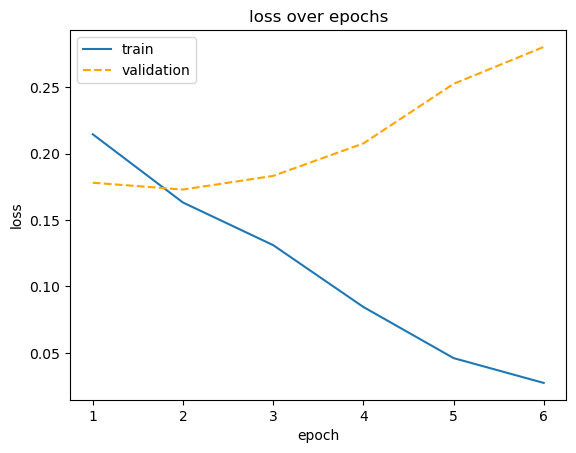

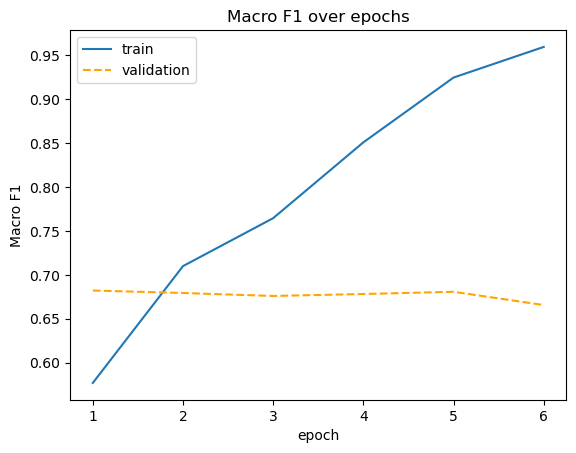

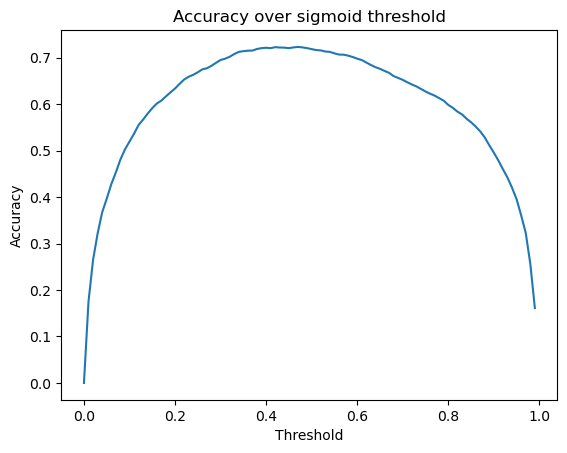

Best threshold: 0.47000000000000003
Best Accuracy: 0.7232655190401669


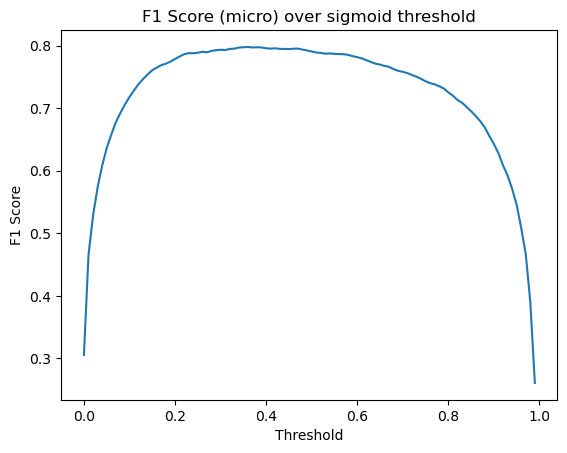

Best threshold: 0.36
Best F1 Score (micro): 0.7979324438033417


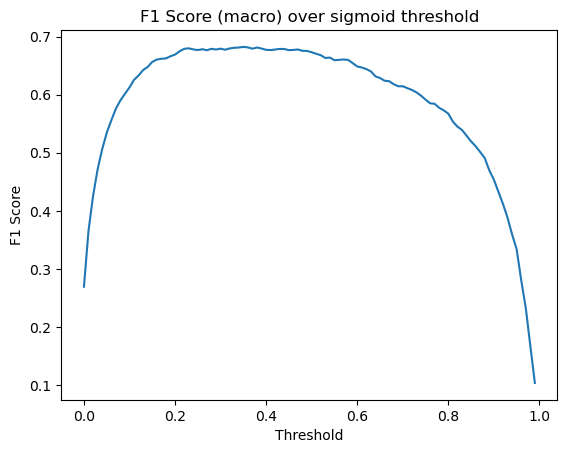

Best threshold: 0.35000000000000003
Best F1 Score (macro): 0.6821244294170691


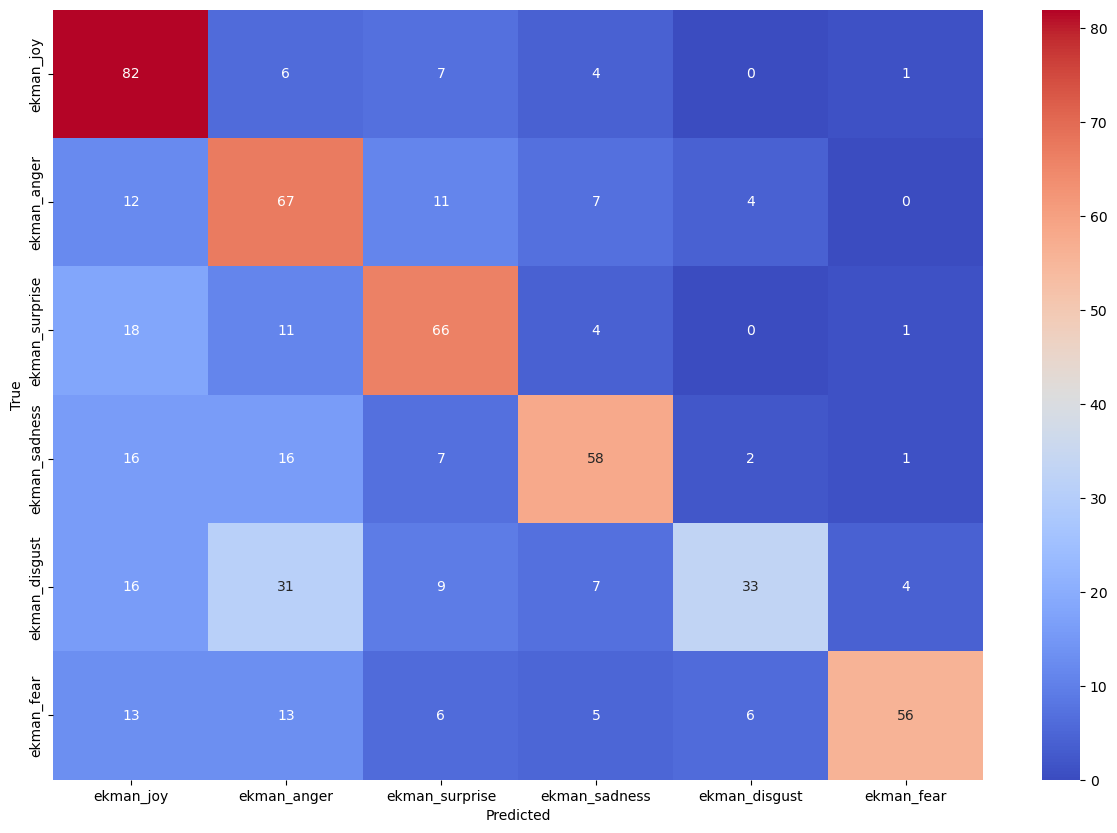

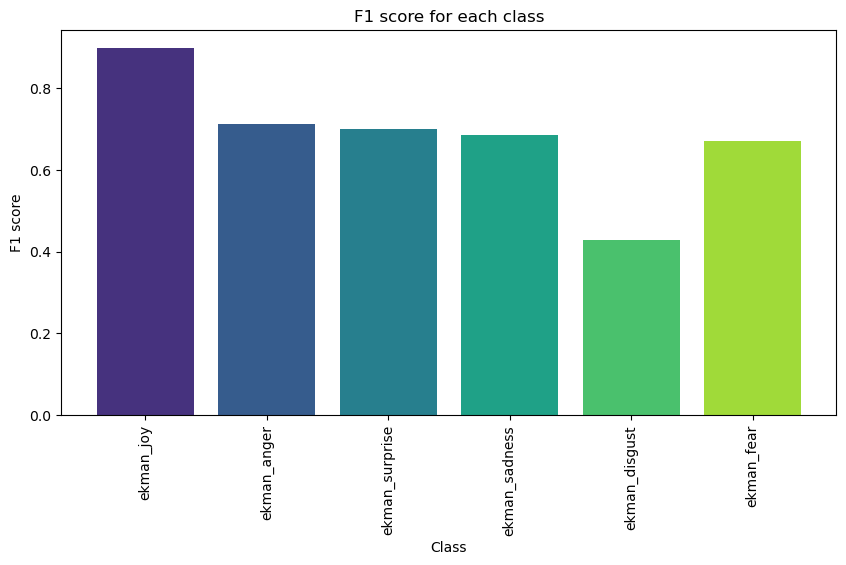

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.92                0.88                0.90                0.81                2219
ekman_anger                         0.67                0.76                0.71                0.55                 717
ekman_surprise                      0.66                0.75                0.70                0.54                 624
ekman_sadness                       0.69                0.68                0.68                0.52                 390
ekman_disgust                       0.49                0.38                0.43                0.27                  97
ekman_fear                          0.74                0.61                0.67                0.50                 105
Macro avg                           0.69                0.68                0.68                0.53                4152
Micro avg

In [18]:
BEST_PARAMS['n_classes'] = len(EKMAN_LABELS)
random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
# model analysis with Ekman mapped emotions
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)
model_analysis(model, val_df, EKMAN_LABELS)

## Mapping with twitter emotions (Parrott taxonomy)

In [20]:
DATASET = DatasetEnum.TwitterDataCleaned
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
train_df, val_df, test_df = load_dataset(DATASET)
TWITTER_LABEL = train_df.columns[1:].tolist()

In [21]:
BEST_PARAMS['n_classes'] = len(TWITTER_LABEL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


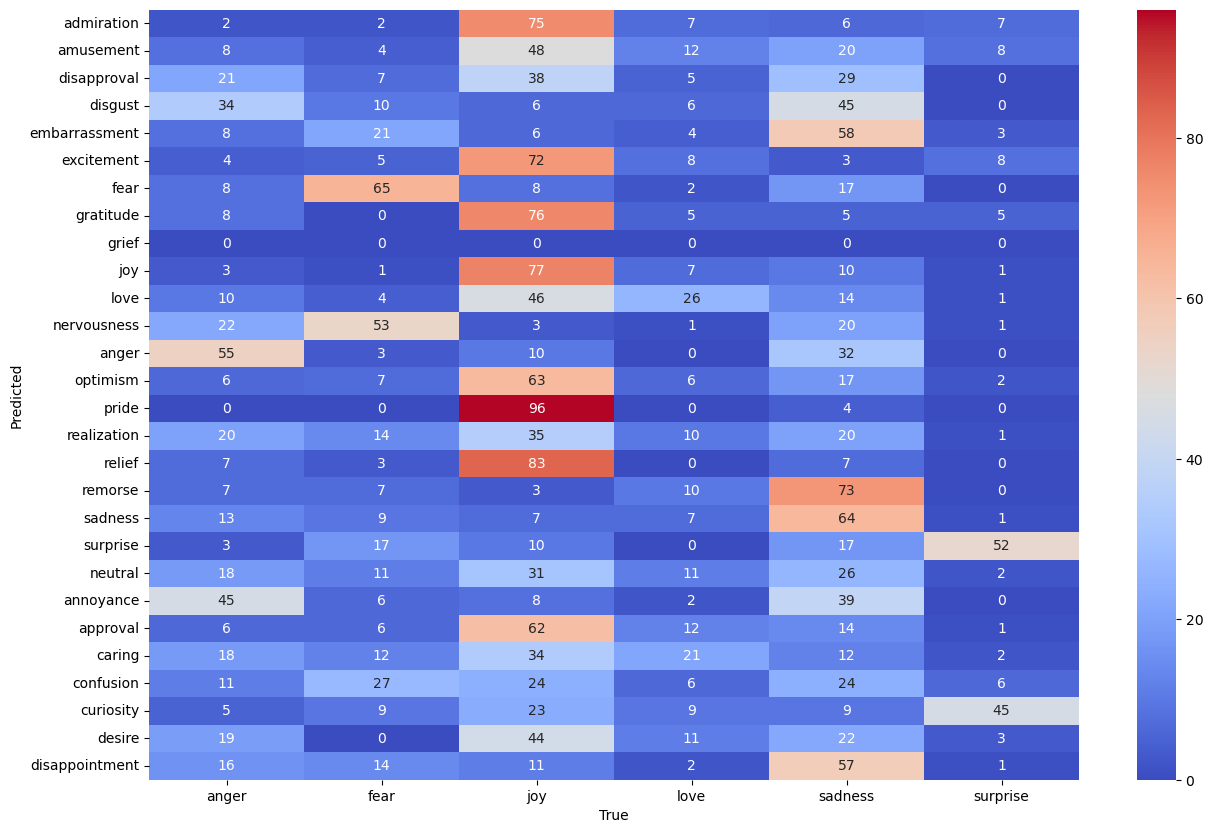

In [22]:
# get model predictions on test set of Twitter dataset
out = model.predict(test_df)
best_out = (out > thresh).astype(int)
# visualize confusion matrix to understand induced mapping
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABEL].values, best_out, TWITTER_LABEL, LABEL_COLS, normalize=True, transpose=True)